In [58]:
from tqdm import tqdm
import torch
from pathlib import Path
# from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from transformers import LayoutLMv3FeatureExtractor, LayoutLMv3TokenizerFast, LayoutLMv3Processor, LayoutLMv3ForSequenceClassification
from torchmetrics import Accuracy
from pytorch_lightning.callbacks import ModelCheckpoint
import json
from PIL import Image, ImageDraw, ImageFont
from typing import List
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [29]:
DOCUMENT_CLASSES = ['email', 'resume', 'scientific_publication']
DOCUMENT_CLASSES

['email', 'resume', 'scientific_publication']

In [30]:
# from torch import nn

# class ModelModule(nn.Module):
class ModelModule(pl.LightningModule):
    def __init__(self, n_classes:int):
        super().__init__()
        self.model = LayoutLMv3ForSequenceClassification.from_pretrained(
            "microsoft/layoutlmv3-base", 
            num_labels=n_classes
        )
        self.model.config.id2label = {k: v for k, v in enumerate(DOCUMENT_CLASSES)}
        self.model.config.label2id = {v: k for k, v in enumerate(DOCUMENT_CLASSES)}
        self.train_accuracy = Accuracy(task="multiclass", num_classes=n_classes)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=n_classes)

    def forward(self, input_ids, attention_mask, bbox, pixel_values, labels=None):
        return self.model(
            input_ids, 
            attention_mask=attention_mask,
            bbox=bbox,
            pixel_values=pixel_values,
            labels=labels
        )

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("train_loss", output.loss)
        self.log("train_acc", self.train_accuracy(output.logits, labels), on_step=True, on_epoch=True)
        return output.loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        bbox = batch["bbox"]
        pixel_values = batch["pixel_values"]
        labels = batch["labels"]
        output = self(input_ids, attention_mask, bbox, pixel_values, labels)
        self.log("val_loss", output.loss)
        self.log("val_acc", self.val_accuracy(output.logits, labels), on_step=False, on_epoch=True)
        return output.loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.00001) #1e-5
        return optimizer

In [32]:
model_module = ModelModule(len(DOCUMENT_CLASSES))
model_checkpoint = ModelCheckpoint(
    filename="{epoch}-{step}-{val_loss:.4f}", save_last=True, save_top_k=3, monitor="val_loss", mode="min"
)

trainer = pl.Trainer(
    precision=16,
    devices=1,
    max_epochs=10,
    callbacks=[
        model_checkpoint
    ],
)

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Tahir iltaf\.conda\envs\layoutlmv3_env\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:751: UserWarning: You passed `Trainer(accelerator='cpu', precision=16)` but native AMP is not supported on CPU. Using `precision='bf16'` instead.
  rank_zero_warn(
Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [38]:
model_path  = "G:/programming/Packagex_assignment/LayoutLMv3/models/version_4/checkpoints/last.ckpt"
trained_model = ModelModule.load_from_checkpoint(
    checkpoint_path = model_path, 
    n_classes=len(DOCUMENT_CLASSES), 
    local_files_only=True
)
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
model = trained_model.model.eval().to(DEVICE)

Some weights of LayoutLMv3ForSequenceClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
def predict_document_image(
    image_path: Path, 
    model: LayoutLMv3ForSequenceClassification, 
    processor: LayoutLMv3Processor):

    json_path = image_path.with_suffix(".json")
    with json_path.open("r") as f:
        ocr_result = json.load(f)

        with Image.open(image_path).convert("RGB") as image:

            width, height = image.size
            width_scale = 1000 / width
            height_scale = 1000 / height
    
            words = []
            boxes = []
            for row in ocr_result:
                boxes.append(
                    scale_bounding_box(
                        row["bounding_box"], 
                        width_scale, 
                        height_scale
                    )
                )
                words.append(row["word"])
    
            encoding = processor(
                image, 
                words,
                boxes=boxes,
                max_length=512,
                padding="max_length",
                truncation=True,
                return_tensors="pt"
            )

    with torch.inference_mode():
        output = model(
            input_ids=encoding["input_ids"].to(DEVICE),
            attention_mask=encoding["attention_mask"].to(DEVICE),
            bbox=encoding["bbox"].to(DEVICE),
            pixel_values=encoding["pixel_values"].to(DEVICE)
        )

    predicted_class = output.logits.argmax()
    return model.config.id2label[predicted_class.item()]

In [ ]:
# words = []
# boxes = []

    
# ocr_result = reader.readtext(str(image_path), batch_size=16)    
# for bbox, word, confidence in ocr_result:
#     boxes.append(scale_bounding_box(create_bounding_box(bbox), width_scale, height_scale))
#     words.append(word)
    

In [53]:
def scale_bounding_box(box: List[int], width_scale : float = 1.0, height_scale : float = 1.0) -> List[int]:
    return [
        int(box[0] * width_scale),
        int(box[1] * height_scale),
        int(box[2] * width_scale),
        int(box[3] * height_scale)
    ]

In [44]:
feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False)
tokenizer = LayoutLMv3TokenizerFast.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor(feature_extractor, tokenizer)

C:\Users\Tahir iltaf\.conda\envs\layoutlmv3_env\lib\site-packages\transformers\models\layoutlmv3\feature_extraction_layoutlmv3.py:30: FutureWarning: The class LayoutLMv3FeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use LayoutLMv3ImageProcessor instead.
  warnings.warn(


In [54]:
image_paths = sorted(list(Path("images").glob("*/*.png")))
test_images = image_paths
labels = []
predictions = []
for image_path in tqdm(test_images):
    labels.append(image_path.parent.name)
    predictions.append(predict_document_image(image_path, model, processor))

  0%|                                                                                          | 0/165 [00:00<?, ?it/s]C:\Users\Tahir iltaf\.conda\envs\layoutlmv3_env\lib\site-packages\transformers\modeling_utils.py:862: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████████████████| 165/165 [08:56<00:00,  3.25s/it]


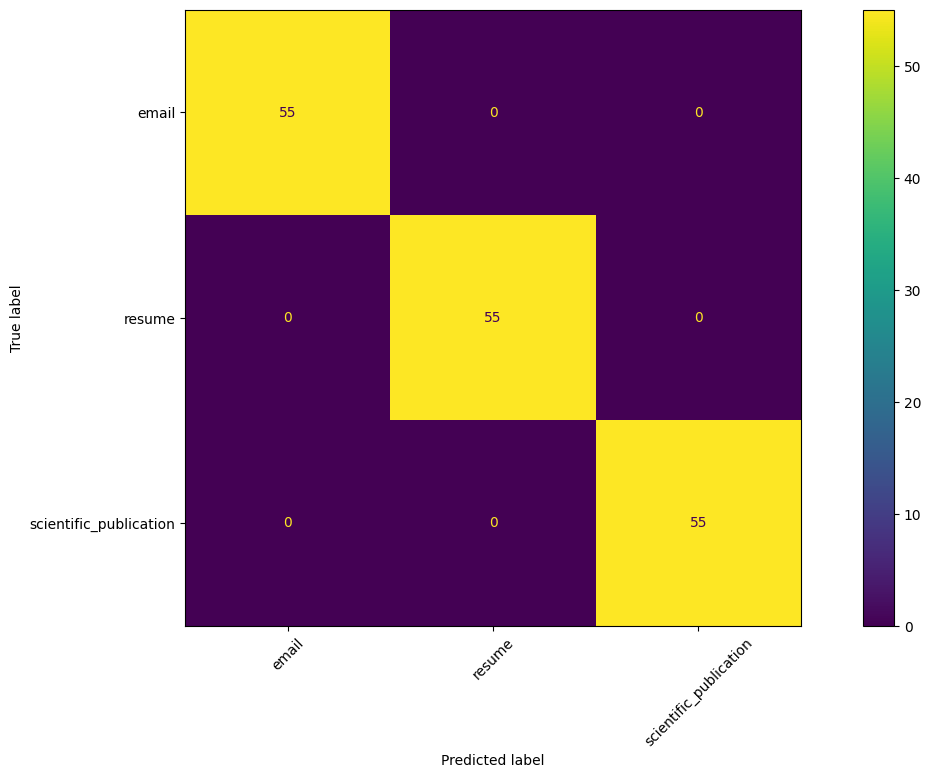

In [59]:
cm = confusion_matrix(labels, predictions, labels=DOCUMENT_CLASSES)
cm_display = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=DOCUMENT_CLASSES
)

cm_display.plot()
cm_display.ax_.set_xticklabels(DOCUMENT_CLASSES, rotation=45)
cm_display.figure_.set_size_inches(16, 8)

plt.show();